Alvaro Viejo (100451677), Rodrigo Oliver (100451788), Oscar Montoya (100451858), Miguel Ángel Ponce (100451309)

In [1]:
from IPython import display
from IPython.core.display import Image

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd
from src.funcs import *

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2022

&nbsp;
&nbsp;
&nbsp;
# Lab 4. Gaussian Processes

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Diabetes dataset

[Diabetes](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) is another classic benchmark for regression. Each observation corresponds to a diabetes patient represented by 10 variables and the corresponding target is a score that measures  the disease progression one year after baseline.

The variables that form each observation are:
- age in years

- sex

- bmi body mass index

- bp average blood pressure

- six measures taken from the blood of the patient:
  - s1 tc, T-Cells (a type of white blood cells)

  - s2 ldl, low-density lipoproteins

  - s3 hdl, high-density lipoproteins

  - s4 tch, thyroid stimulating hormone

  - s5 ltg, lamotrigine

  - s6 glu, blood sugar level


In [4]:

data = pd.read_csv('diabetes.csv', header=0)
data.columns = ['AGE', 'SEX', 'BMI', 'BP','TC','LDL','HDL','TCH','LTG','GLU','Y']
feature_names = data.columns.copy() # list with feature names
print("Feature names are")
for ii,fn  in enumerate(feature_names[:-1]):
    print("Column {0:d}: {1}".format(ii,fn))
X = data.values[:,:-1]
Y = data['Y'].values
print("")
print("Loaded {0:d} observations with {1:d} columns".format(X.shape[0], X.shape[1]))
print("Loaded {0:d} targets".format(len(Y)))


Feature names are
Column 0: AGE
Column 1: SEX
Column 2: BMI
Column 3: BP
Column 4: TC
Column 5: LDL
Column 6: HDL
Column 7: TCH
Column 8: LTG
Column 9: GLU

Loaded 442 observations with 10 columns
Loaded 442 targets


# Splitting into training and test set

Divide the data set into a training set with $2/3$ of the observations.

We use the train_test_split function of sklearn:

In [5]:
from sklearn.model_selection import train_test_split

train_test_prop = 2/3
X_train, X_test, y_train, y_test = train_test_split(X,Y, 
    train_size = train_test_prop, random_state=42)

# Check sizes are correct
print(f"{len(X_train)=}")
print(f"{len(X_test)=}")

len(X_train)=294
len(X_test)=148


# 1. Gaussian Process Regression initial result

Train a Gaussian Process with a composite kernel formed with the sum of:
  - RBF kernel:
     - `length_scale`= 1.5
     - `length_scale_bounds` [1e-2, 1e3]
  - White noise kernel:
     - `noise_level`=0.1
     - `noise_level_bounds` [1e-10, 1e6]
     
**Print the performance of the model in the test set.**

**Print the values of the kernel parameters after the GP optimization.**

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

noise_variance = .1

# instantiate the composite kernel
kernel_1 = 1.0 * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10,1e6))

# instantiate the GP
gpr = GaussianProcessRegressor(kernel=kernel_1, random_state=42, n_restarts_optimizer=10)

# GaussianProcessRegressor(n_restarts_optimizer=10) this is in case we have the bad luck to get stuck and it makes it repeat the process

gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X_test, return_std=True)

# Print results
print("Score in the test set:", gpr.score(X_test, y_test), "\n")
print(gpr.get_params())

print("\nOPTIMIZED KERNEL:",gpr.kernel_)


Score in the test set: 0.46656122987718807 

{'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2 * RBF(length_scale=1.5), 'kernel__k2': WhiteKernel(noise_level=0.1), 'kernel__k1__k1': 1**2, 'kernel__k1__k2': RBF(length_scale=1.5), 'kernel__k1__k1__constant_value': 1.0, 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k1__k2__length_scale': 1.5, 'kernel__k1__k2__length_scale_bounds': (0.01, 1000.0), 'kernel__k2__noise_level': 0.1, 'kernel__k2__noise_level_bounds': (1e-10, 1000000.0), 'kernel': 1**2 * RBF(length_scale=1.5) + WhiteKernel(noise_level=0.1), 'n_restarts_optimizer': 10, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 42}

OPTIMIZED KERNEL: 316**2 * RBF(length_scale=171) + WhiteKernel(noise_level=3.22e+03)


d:\Anaconda3\envs\Machine_Learning_II\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


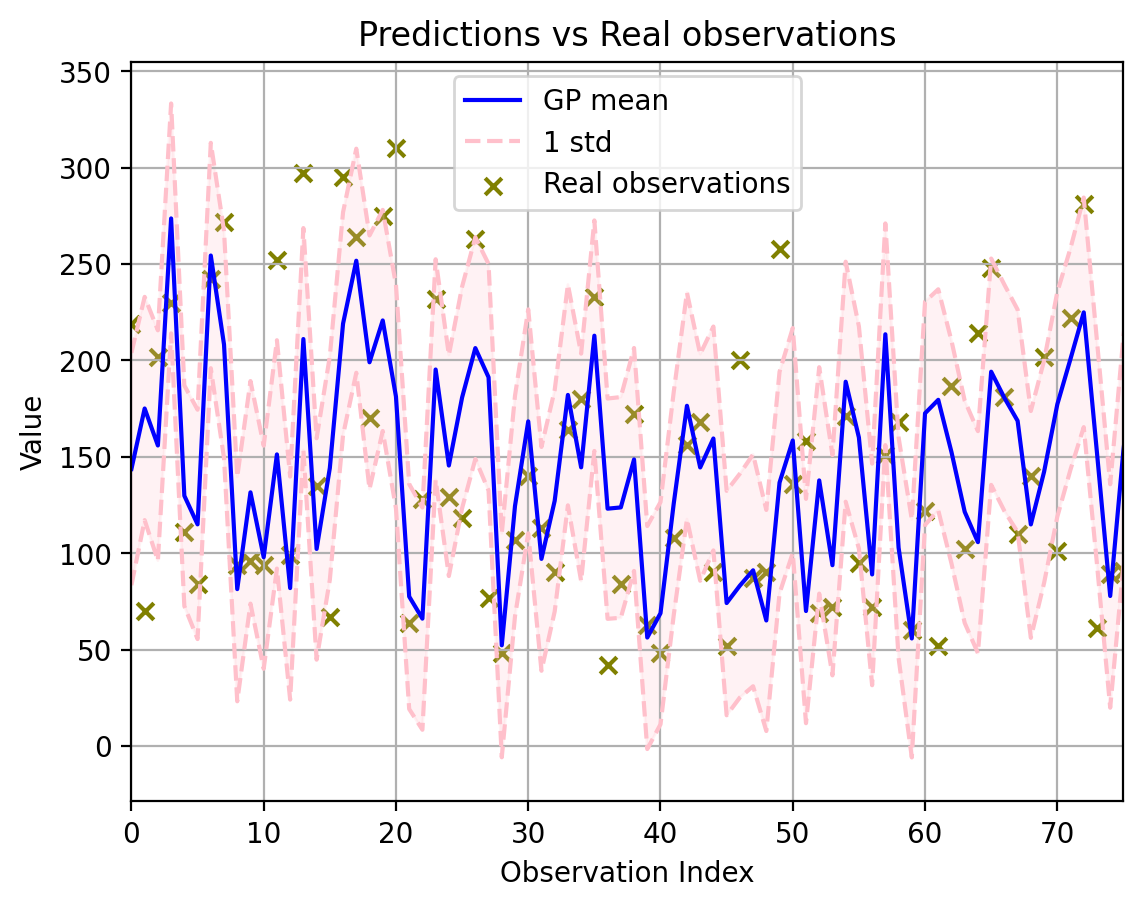

In [7]:
plotGPRresults(y_mean, y_std, y_test, xlim=(0, 75))

### Your comments:

**Discuss about the differences between the kernel parameters before and after optimizing the GP.**

We can clearly see that the kernel has been optimized as the values of the parameters have changed. The kernel describes the covariance of the GP r.v..


# 2. Strategies to improve the initial result

In this assignment we are going to explore three strategies to improve this initial result

1. Scaling the data
2. Feature selection
3. Kernel design

## 2.1 Scaling the data

Repeat the experiment that produced the baseline result scaling the observations with a `MinMaxScaler` and evaluate the impact of this scaling in the performance of the GP. 

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
# Get the scale parameters of the training test
X_train_sca = scaler.fit_transform(X_train)
# Fit the test with the train set parameters
X_test_sca = scaler.transform(X_test)

X_train_sca=pd.DataFrame(X_train_sca)
X_test_sca=pd.DataFrame(X_test_sca)


gpr_scaled=gpr
gpr_scaled.fit(X_train_sca, y_train)
y_mean, y_std = gpr_scaled.predict(X_test_sca, return_std=True)

# Print results
print("Score in the test set:", gpr_scaled.score(X_test_sca, y_test), "\n")
print(gpr_scaled.get_params())

print("\nOPTIMIZED KERNEL:",gpr_scaled.kernel_)



Score in the test set: 0.526063643395609 

{'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2 * RBF(length_scale=1.5), 'kernel__k2': WhiteKernel(noise_level=0.1), 'kernel__k1__k1': 1**2, 'kernel__k1__k2': RBF(length_scale=1.5), 'kernel__k1__k1__constant_value': 1.0, 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k1__k2__length_scale': 1.5, 'kernel__k1__k2__length_scale_bounds': (0.01, 1000.0), 'kernel__k2__noise_level': 0.1, 'kernel__k2__noise_level_bounds': (1e-10, 1000000.0), 'kernel': 1**2 * RBF(length_scale=1.5) + WhiteKernel(noise_level=0.1), 'n_restarts_optimizer': 10, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 42}

OPTIMIZED KERNEL: 271**2 * RBF(length_scale=3.7) + WhiteKernel(noise_level=3.04e+03)


### Your comments:

**Did scaling improve the accuracy of the GP?**

- As it can be seen, scaling resulted in 13.02%% accuracy increase going from an accuracy of 0.466 to an accuracy of 0.5267


**Did scaling affect to the final value of the kernel parameters after the optimization?**
- All kernel parameters' values have decreased. Both the `noise_level` and the scaling factor have been scaled, and the `length_scale` parameter has significantly decreased.

## 2.2 Feature selection

The goal in this strategy is to study
- if any of the variables is noisy (its presence worsens the performance of the regressors)
- if any of the variables is not relevant (its presence or absence does not affect the performance of the regressor, hence you could save resources by skipping its measure
- if some of these variables are more critical than the others in the conformation of the score. This way you can gain insights about the main drivers of the disease.

We will explore two strategies to perform the feature selection

1. Random Forests property `feature_importances_`.  

2. GP with an ARD kernel



### 2.2.1 Random Forests `feature_importances_`

In Random Forest the variables are individually selected to design the stump test in each branch node of each tree in the forest. Relevant variables will be in general oftenly selected for these test, while noisy or redundant variables will be selected less oftenly.  Besides, since the growing of each tree only considers a subset of the training data, the left-out subset can be used as validation set to evaluate the quality of each stump. In this sense, the most relevant variables will lead to better quality stumps.

In the sklearn implementation of Random Forest there is a property `feature_importances_` that is precisely a score in the relevance of the features.


In the following cell write code that
 1. Train a Random Forest Regressor with its hyperparameters selected by cross-validation within the following  ranges
  - number of trees: 10, 20, 50, 100, 200, 500, 1000
  - maximum number of leaves per node: 5, 10, 20, 50
  
 2. Print the score in the test set  of the Random Forest fitted with the best set of hyperparameters
 
 3. Print the value of `feature_importances_` for each feature in the data set
 
 4. Sort the features in order of decreasing importance in an array called `random_forest_order`
 
 

We will use the GridSearchCV for the cross-validation of the best hyperparameters:

In [9]:
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create the Parameter Grid
hypams = {
    "n_estimators": [10,20,50,100,200,500,1000], #ntrees
    "max_leaf_nodes": [5,10,20,50]
}
# Set the seed for the model
random.seed(290781)
# Create the Model
rforest_reg = RandomForestRegressor()
# grid search with cv:
grid_rf_reg = GridSearchCV(rforest_reg, hypams)

# fit the model
grid_fit = grid_rf_reg.fit(X_train, y_train)

best_max_leaf=grid_rf_reg.best_params_['max_leaf_nodes']
best_n_estimators=grid_rf_reg.best_params_['n_estimators']

final_rf = RandomForestRegressor(
    n_estimators=best_n_estimators,
    max_leaf_nodes=best_max_leaf
    )

rforest_reg_importance = final_rf.fit(X_train, y_train).feature_importances_

#Evaluation with test set
test_error_gridrf_reg =  grid_rf_reg.score(X_test,y_test)

"""
PRINT THE RESULTS
"""
print("Test Set Score with best parameters")
print(np.round(test_error_gridrf_reg,3))
print("Best parameters")
print(grid_rf_reg.best_params_)

print("Feature importance: \n", rforest_reg_importance)


Test Set Score with best parameters
0.472
Best parameters
{'max_leaf_nodes': 20, 'n_estimators': 200}
Feature importance: 
 [0.04371835 0.0055467  0.45420282 0.12956427 0.03896018 0.04633509
 0.04283925 0.01492126 0.18678612 0.03712596]


Importances sorted:

In [10]:
rforest_reg_importance_s=np.sort(rforest_reg_importance)[::-1]

# Print the feature_names of each importance sorted
print("Feature importances:")
print("\n".join(
    [f"{str(feature_names[np.where(rforest_reg_importance == score)][0])}:\t{score}" \
        for score in rforest_reg_importance_s]
))

print(f"\n{sum(rforest_reg_importance_s)=}") #All importances sum up to 1

Feature importances:
BMI:	0.454202815160424
LTG:	0.18678612208247763
BP:	0.12956427098917303
LDL:	0.046335092447288936
AGE:	0.043718348243238406
HDL:	0.04283924940432345
TC:	0.03896017644099661
GLU:	0.0371259557451075
TCH:	0.014921264674579899
SEX:	0.005546704812390455

sum(rforest_reg_importance_s)=0.9999999999999999


### Your comments:

**Did RF perform in the test set better than GP?**
- The `RandomForest` model did better than unscaled version of the GP (by a 3.86%), but underperformed the scaled version of the Gaussian process (by a 8.88%).

**What are the more relevant features according to RF?**
- As we can see, the most relevant features in the RF model are the **Body mass index (BMI)**, **Lamotrigine (LTG)**, and the **Blood Preassure (BP)**.

**Are there significant differences in relevance among the features?**
- Yes there are, specially for the Body mass index (BMI) variable, which takes about 45% of the total importance.


In the next cell write code that implements a `for loop` that in each iteration trains a GP with the settings of Section 1 but increasing the number of features in the ordering suggested by `random_forest_order`. 

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

First we need to create a list for every feature so we can add one by one by importance:

In [11]:
# Create a list with the feature indeces ordered by importance
list_features=[int(np.where(rforest_reg_importance == score)[0])\
    for score in rforest_reg_importance_s]

print(f"{list_features=}")

list_features=[2, 8, 3, 5, 0, 6, 4, 9, 7, 1]


In [12]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore') 

In [13]:
# Get the number of variables
n_vars = len(feature_names)-1
scores=np.zeros(n_vars)
columns_used=np.zeros(n_vars)

for i in range(n_vars):
    # Select the number of features
    cols = list_features[:i+1]

    # Fit the model with that number of variables
    #NOTE: Don't scale the data as in section 1
    gpr.fit(X_train[:, cols], y_train)

    # Get the prediction mean and std
    y_mean, y_std = gpr.predict(X_test[:, cols], return_std=True)

    # Compute the correlation coefficient between our prediction
    # and the real test set
    gpr_score=gpr.score(X_test[:,cols], y_test)

    # Store the resutls
    scores[i] = gpr_score
    columns_used[i] = i+1

    #Print data
    print("\n----------------------------------------------------------------------")
    print("Variables used:", [feature_names[i] for i in cols],"\n")
    print("Score in the test set:", gpr_score, "\n")
    print("OPTIMIZED KERNEL:",gpr.kernel_)
    print("----------------------------------------------------------------------")


----------------------------------------------------------------------
Variables used: ['BMI'] 

Score in the test set: 0.31661846495274504 

OPTIMIZED KERNEL: 311**2 * RBF(length_scale=38.7) + WhiteKernel(noise_level=3.93e+03)
----------------------------------------------------------------------

----------------------------------------------------------------------
Variables used: ['BMI', 'LTG'] 

Score in the test set: 0.4872838544425827 

OPTIMIZED KERNEL: 316**2 * RBF(length_scale=15.8) + WhiteKernel(noise_level=3.44e+03)
----------------------------------------------------------------------

----------------------------------------------------------------------
Variables used: ['BMI', 'LTG', 'BP'] 

Score in the test set: 0.4369617966940854 

OPTIMIZED KERNEL: 316**2 * RBF(length_scale=43.4) + WhiteKernel(noise_level=3.32e+03)
----------------------------------------------------------------------

----------------------------------------------------------------------
Variables 

In [14]:
print(X_train)
print(X_test_sca.head())
print(X_test)
print(X_test_sca)

[[ 51.       2.      25.9    ...   6.       5.0752  96.    ]
 [ 59.       2.      25.5    ...   5.43     4.3567 117.    ]
 [ 56.       2.      28.7    ...   5.       4.7274  97.    ]
 ...
 [ 57.       1.      24.5    ...   3.       4.5218  91.    ]
 [ 45.       1.      24.2    ...   4.       4.2195  82.    ]
 [ 23.       1.      29.     ...   3.       4.585   91.    ]]
          0    1         2         3         4         5         6         7  \
0  0.700000  0.0  0.331897  0.394366  0.890052  0.765936  0.428571  0.423131   
1  0.916667  0.0  0.504310  0.549296  0.319372  0.314741  0.363636  0.141044   
2  0.783333  1.0  0.340517  0.408451  0.806283  0.522908  0.558442  0.282087   
3  0.933333  0.0  0.564655  0.784085  0.623037  0.484064  0.090909  0.832158   
4  0.550000  1.0  0.275862  0.450704  0.560209  0.536853  0.337662  0.423131   

          8         9  
0  0.574871  0.484848  
1  0.343957  0.424242  
2  0.793641  0.439394  
3  0.853132  0.727273  
4  0.416970  0.469697  
[[ 

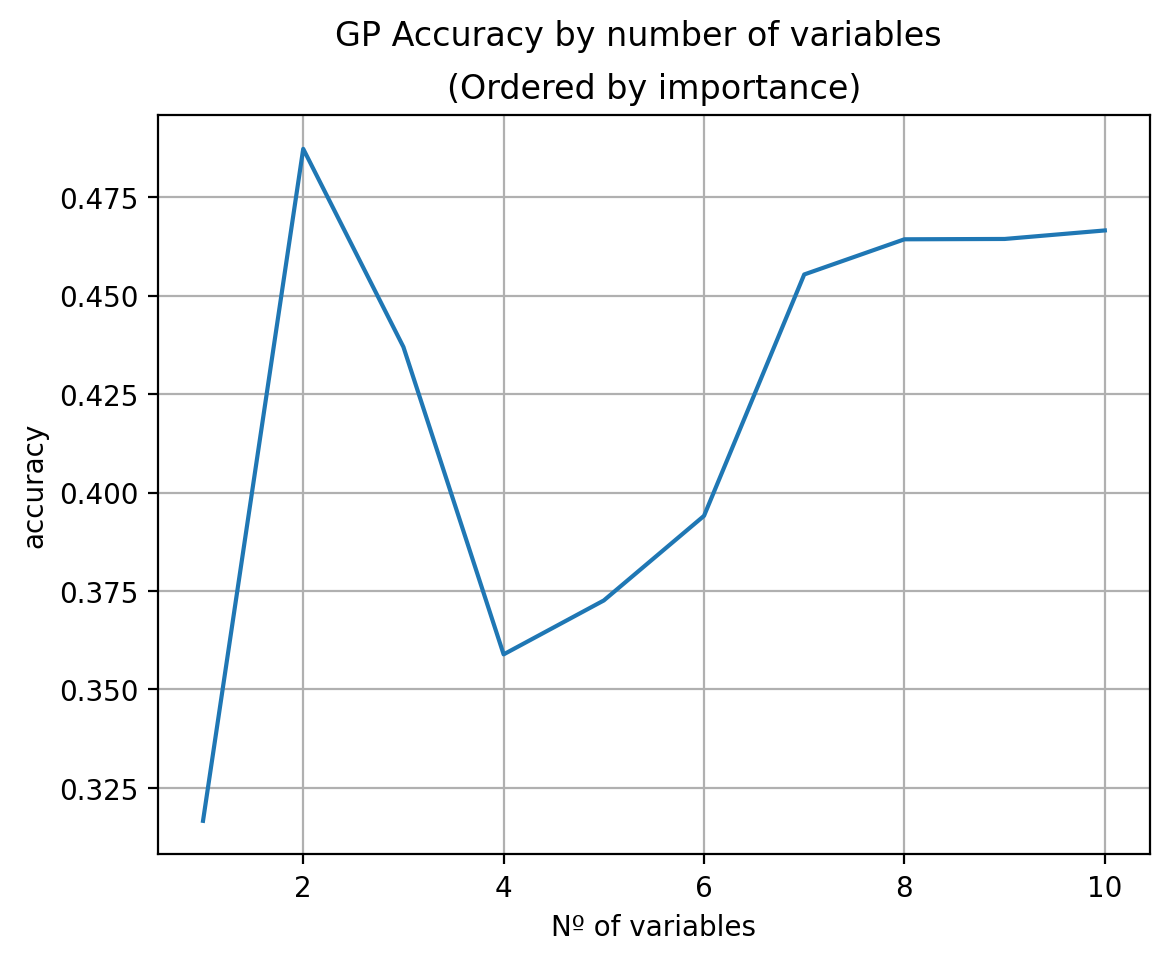

In [15]:
plt.plot(columns_used, scores)
plt.suptitle("GP Accuracy by number of variables")
plt.title("(Ordered by importance)")
plt.ylabel('accuracy')
plt.xlabel('Nº of variables')
plt.grid()

### Your comments:

**What is the best number of features to model the problem?**
- The best number of features to model the problem is 2 as it is the number of features (with the two most important variables: BMI, LTG) that maximizes the accuracy of the model.

**Does removing features improve the performance of RF?**
- Yes, removing features improves the performance of the model as we can obtain a better performance by merely using the two most important variables than employing all of them. This shows, as will be explained in the next question, that the remaining variables are a significant source of noise.

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**
- Yes, there are noisy features, in fact, we can readily notice by looking at the above plot that the performance of the model is severely degraded by the addition of the third, fourth, fifth, sixth and seventh most important variables, they are: BP, AGE, LDL, HDL and GLU.



### 2.2.2 GP with an ARD kernel

The fitting of a GP endowed with an anisotropic RBF kernel obtains a different value of the `length_scale` for each variable.

**Relate the length scale of each variable with its relevance in the predictive function**

Hint: Consider how does the output of the predictive function changes as the value of a certain variable $x_k$ changes depending on $l_k^2$.

In the next cell write code that fits a GP with an ARD kernel. 

**Print the lengthscale value of each feature after the kernel has been optimized** Hint, learn to use `kernel.get_params()`. 

**Sort the features in order of decreasing importance in an array called `ARD_order`**

**Print the score in the test set  of the GP with ARD kernel**

In order to use an anisotropic kernel, the length_scale value of the parameters must be now an array, in which each dimension of the length defines the length scale of the respective feature dimension. First we will make the model and it's fit and after that we will talk about the relevance of the length scale and do the ARD_order.

In [16]:
from sklearn.linear_model import ARDRegression

# define ARD kernel
kernel_2 = 1.0 * RBF(
    length_scale = np.ones(10)*1.5,
    length_scale_bounds=(1e-2, 1e5),
    ) + WhiteKernel()

# instantiate the GP
gpr_2 = GaussianProcessRegressor(
    kernel=kernel_2,
    random_state=42,
    n_restarts_optimizer=10
    )

gpr_2.fit(X_train, y_train)
y_mean, y_std = gpr_2.predict(X_test, return_std=True)

print(gpr_2.kernel_)
print("Score in the test set:", gpr_2.score(X_test, y_test), "\n")
print(gpr_2.get_params())

281**2 * RBF(length_scale=[4.54e+04, 14, 33.6, 187, 2.22e+03, 9.92e+04, 268, 2.51e+03, 8.03, 1.98e+04]) + WhiteKernel(noise_level=3.01e+03)
Score in the test set: 0.5202295833727992 

{'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2 * RBF(length_scale=[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]), 'kernel__k2': WhiteKernel(noise_level=1), 'kernel__k1__k1': 1**2, 'kernel__k1__k2': RBF(length_scale=[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]), 'kernel__k1__k1__constant_value': 1.0, 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k1__k2__length_scale': array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]), 'kernel__k1__k2__length_scale_bounds': (0.01, 100000.0), 'kernel__k2__noise_level': 1.0, 'kernel__k2__noise_level_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]) + WhiteKernel(noise_level=1), 'n_restarts_optimizer': 10, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'ran

So, before doing the ARD_order we will relate the length scale to the importance of each feature for the model and the predictive function. For that we will print again the final kernel:



In [17]:
print(gpr_2.kernel_)

281**2 * RBF(length_scale=[4.54e+04, 14, 33.6, 187, 2.22e+03, 9.92e+04, 268, 2.51e+03, 8.03, 1.98e+04]) + WhiteKernel(noise_level=3.01e+03)


As we can see we have bigger and smaller values, what do they mean? An small lengthscale means the function values can change quickly  while large ones characterize function features that vary less or slower. 

So, for characterizing which is more important we could say that those with LOWER lengthscales will have a bigger influence on the model as are those ones which will vary more, and in the other hand, those with higher values are features varying less so they can be almost irrelevant for the model.

In fact here we can see that columns 2 and 9 have the lower values, meaning they are more relevant, and if we compare this with the last section selection of features some similarities can be obtained.

Now let's put them in order:

In [18]:
# WE GET THE FEATURES IN ORDER
weights = gpr_2.kernel_.get_params()["k1__k2__length_scale"].tolist()
weights_iter = weights.copy()
s_weights = np.sort(weights)
# ARD_order = {feature_names[np.where(np.round(weights,2) == np.round(w,2))][0]: w for w in s_weights}

ARD_order = {}
for w in s_weights:
    w_ind = np.where(np.round(weights_iter,2) == np.round(w,2))[0][0]
    val = weights_iter[w_ind]
    weights_iter[w_ind] = 0
    ARD_order[feature_names[w_ind]] = val



# Print the length scale of the variables
print("Lenght scale of every variable:")
print("\n".join(
    [f"{tuple(ARD_order.keys())[i]}:\t{tuple(ARD_order.values())[i]}"
     for i in range(len(s_weights))]
))


Lenght scale of every variable:
LTG:	8.032373398553743
SEX:	13.97700617648778
BMI:	33.59028600499143
BP:	186.69784539450174
HDL:	267.993682544227
TC:	2217.2660200777473
TCH:	2509.5375495684934
GLU:	19769.31882363849
AGE:	45360.763588105285
LDL:	99174.46872012758


In the next cell write code that implements a `for loop` that in each iteration trains a GP with an ARD kernel but increasing the number of features in the ordering suggested by `ARD_order`. 

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

In [19]:
# Create a list with the feature indeces ordered by length scale
f_names  = list(feature_names)
list_features_ard=[f_names.index(val) \
    for val in ARD_order.keys()]

print(f"{list_features_ard=}")

list_features_ard=[8, 1, 2, 3, 6, 4, 7, 9, 0, 5]


In [20]:
# Get the number of variables
n_vars = len(feature_names)-1
scores = np.zeros(n_vars)
columns_used = np.zeros(n_vars)

for i in range(n_vars):
    # Select the number of features
    cols = list_features_ard[:i+1]

    # define ARD kernel
    kernel_3 = 1.0 * RBF(length_scale=np.ones(i+1)*1.5, length_scale_bounds=(1e-2, 1e4)) \
        + WhiteKernel()

    # instantiate the GP
    gpr_3 = GaussianProcessRegressor(kernel=kernel_3,
                                     random_state=42,
                                     n_restarts_optimizer=10)

    # Fit the model with that number of variables
    # NOTE: Don't scale the data as in section 1
    gpr_3.fit(X_train[:, cols], y_train)

    # Get the prediction mean and s
    y_mean, y_std = gpr_3.predict(X_test[:, cols], return_std=True)

    # Compute the correlation coefficient between our prediction
    # and the real test set
    gpr_3_score = gpr_3.score(X_test[:, cols], y_test)

    # Store the resutls
    scores[i] = gpr_3_score
    columns_used[i] = i+1

    # Print data
    print("\n----------------------------------------------------------------------")
    print("Variables used:", [feature_names[i] for i in cols], "\n")
    print("Score in the test set:", gpr_3_score, "\n")
    print("OPTIMIZED KERNEL:", gpr_3.kernel_)
    print("----------------------------------------------------------------------")



----------------------------------------------------------------------
Variables used: ['LTG'] 

Score in the test set: 0.4614855205692171 

OPTIMIZED KERNEL: 139**2 * RBF(length_scale=1.73) + WhiteKernel(noise_level=4.44e+03)
----------------------------------------------------------------------

----------------------------------------------------------------------
Variables used: ['LTG', 'SEX'] 

Score in the test set: 0.4614850625724596 

OPTIMIZED KERNEL: 139**2 * RBF(length_scale=[1.73, 5.9e+03]) + WhiteKernel(noise_level=4.44e+03)
----------------------------------------------------------------------

----------------------------------------------------------------------
Variables used: ['LTG', 'SEX', 'BMI'] 

Score in the test set: 0.5026071419213924 

OPTIMIZED KERNEL: 280**2 * RBF(length_scale=[6.81, 1e+04, 31.1]) + WhiteKernel(noise_level=3.44e+03)
----------------------------------------------------------------------

-------------------------------------------------------

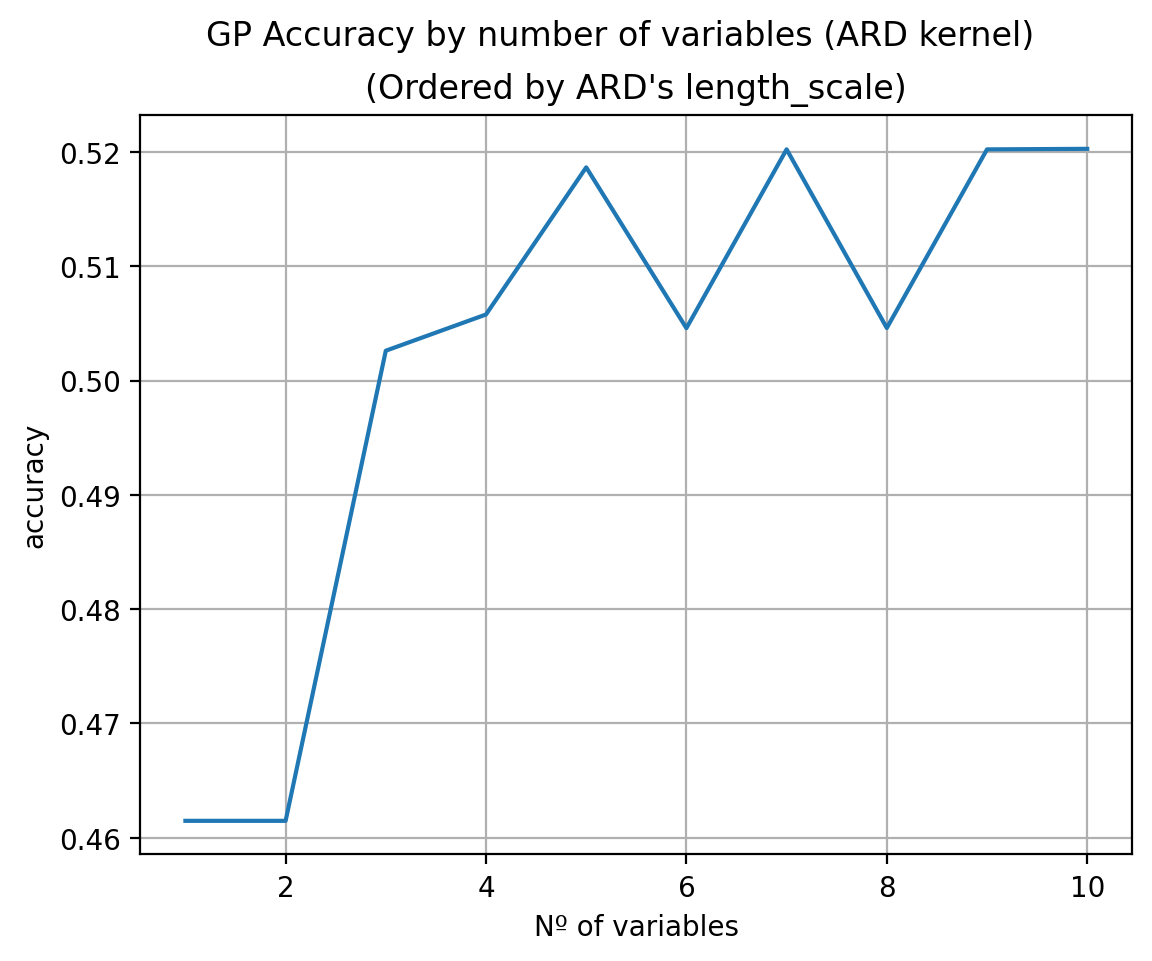

In [21]:
# print(columns_used)
# print(scores)
plt.plot(columns_used, scores)
plt.suptitle("GP Accuracy by number of variables (ARD kernel)")
plt.title("(Ordered by ARD's length_scale)")
plt.ylabel('accuracy')
plt.xlabel('Nº of variables')
plt.grid()

### Your comments:

**What is the best number of features to model the problem according to the ARD kernel?**
- As it can be seen in the graph, the best number of features is $8$. More than that results in the same accuracy. This is taking into account that $4$ variables ('LTG', 'SEX', 'BMI' & 'BP') give almost the same accuracy as having all the variables (0.51 vs 0.52) respectively.

**Does removing features improve the performance of RF?**
- As long as we have the four features 'LTG', 'SEX', 'BMI' & 'BP', adding or removing features does not significantly change the accuracy.

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**
- As the length scales for noisy features get larger, their contribution is less significant, making the accuracy stay the same if they are added. This variables are AGE, and LDL.

**How does the feature selection suggested by the ARD kernel compare with that suggested by random forest?**

In [22]:
# Requirement to build the table
# type pip install tabulate
import tabulate

# Header for the table
header=("Random Forest (variable importances)", "GP ARD kernel (length scales)")

RF_results = [f"{str(feature_names[np.where(rforest_reg_importance == score)][0])}: {score}" \
        for score in rforest_reg_importance_s]

ARD_GP_results = [f"{tuple(ARD_order.keys())[i]}: {tuple(ARD_order.values())[i]}"
     for i in range(len(weights))]

print(tabulate.tabulate(zip(RF_results,ARD_GP_results), headers=header, tablefmt="github"))

| Random Forest (variable importances)   | GP ARD kernel (length scales)   |
|----------------------------------------|---------------------------------|
| BMI: 0.454202815160424                 | LTG: 8.032373398553743          |
| LTG: 0.18678612208247763               | SEX: 13.97700617648778          |
| BP: 0.12956427098917303                | BMI: 33.59028600499143          |
| LDL: 0.046335092447288936              | BP: 186.69784539450174          |
| AGE: 0.043718348243238406              | HDL: 267.993682544227           |
| HDL: 0.04283924940432345               | TC: 2217.2660200777473          |
| TC: 0.03896017644099661                | TCH: 2509.5375495684934         |
| GLU: 0.0371259557451075                | GLU: 19769.31882363849          |
| TCH: 0.014921264674579899              | AGE: 45360.763588105285         |
| SEX: 0.005546704812390455              | LDL: 99174.46872012758          |


| Random Forest (variable importances)   | GP ARD kernel (length scales)   |
|----------------------------------------|---------------------------------|
| BMI: 0.5064143485063581                | LTG: 8.027427439833525          |
| LTG: 0.20312937356115648               | SEX: 13.950213264160448         |
| BP: 0.13069842672536866                | BMI: 33.5836407393836           |
| HDL: 0.03918308684639429               | BP: 186.63230813530214          |
| GLU: 0.028531420842008697              | HDL: 267.69873549810575         |
| AGE: 0.026768801896907758              | TC: 2215.944906247501           |
| LDL: 0.024529111445624897              | TCH: 2517.9444595769055         |
| TC: 0.020410900060136357               | GLU: 19950.505581559828         |
| TCH: 0.017893110945373117              | AGE: 45299.65409493846          |
| SEX: 0.0024414191706715028             | LDL: 100000.00000000001         |

We can see that both models flag variables `BMI`, `LTG` and `BP` as important one.

The most notable difference is that the Random forest model flags `SEX` as a non important variable, but the Gaussian Process with the ARD kernel shows that it is the second most important variable

This may be due to multicollinearity inside our data.

# 4. Exploring sophisticate kernels for the GP

The greatest potentiality of GPs are the exploration of different kernels that capture the geometry of the inputs. 

Besides, the essential kernels can be combined into more sophisticate ones using the addition and multiplication operations.

And the most interesting feature, the GP implementation is able to optimize the parameters of the kernel maximizing the likelihood of the observations, what saves the crossvalidation step for optimizing parameters.

Read the [section 1.7.5 of this site](https://scikit-learn.org/stable/modules/gaussian_process.html) to learn the different kernels that are implemented in the scikit learn distribution of Gaussian Processes.

In this section check at least ten different kernel configurations and evaluate if they improve the kernel evaluated in section 1. Remember this kernel was

$$
\kappa_1(\mathbf x_i, \mathbf x_j) = \kappa_r(\mathbf x_i, \mathbf x_j) + \kappa_w(\mathbf x_i, \mathbf x_j)
$$ 

where

- $\kappa_r(\mathbf x_i, \mathbf x_j)$ is an isotropic RBF kernel with length_scale $l$: 

$$
\kappa_r(\mathbf x_i, \mathbf x_j) = \exp\left( -\frac{\|\mathbf x_i - \mathbf x_j\|^2}{2l^2}\right)
$$

- $\kappa_w(\mathbf x_i, \mathbf x_j)$ is a WhiteKernel that explains the additive noise component

$$\kappa_w(\mathbf x_i, \mathbf x_j) = \left \{ \begin{array}{ll} \sigma_n^2 & \textrm{if } \mathbf x_i== \mathbf x_j \\ 0 & \textrm{otherwise} \end{array}\right.$$

Within the kernel combinations to explore you can include:
1. Add a `ConstantKernel` to $\kappa_1(\mathbf x_i, \mathbf x_j)$

2. Replace $\kappa_r(\mathbf x_i, \mathbf x_j)$ by an anisotropic RBF in $\kappa_1(\mathbf x_i, \mathbf x_j)$. 

3. Individual kernels presented in the lecture

4. Addition of several kernels

5. Multiplication of several kernels

6. Use your imagination!

We will use the different kernel combinations to characterize how difficult is the problem at hand in terms of how difficult is to find out a kernel that achieves the best possible result in the test set.

For this purpose:
1. Group in a same array all the scores in the **test set** achieved by all the kernel combinations that you explore in this section. Consider carrying out this exploration in a programatic fashion.

2. Discuss about the range of test accuracies that can be reached with GPs when the kernel is more carefully designed. Depending on the number of different kernels explored you might consider adding to your discussion
- minimum, maximum, mean values
- standard deviations
- percentiles
- histogram

In [23]:
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct, ExpSineSquared, RationalQuadratic, Matern
from tqdm import tqdm

# For the anisotropic RBF kernel
list_features=[int(np.where(rforest_reg_importance == score)[0])\
    for score in rforest_reg_importance_s]

# Declare the kernels:
kernel1 = 1.0 * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e3)) +\
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10,1e6))

kernel2 = 1.0 * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e3)) +\
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10,1e6)) +\
    ConstantKernel() # the first one plus the ConstantKernel

kernel3 = 1.0 * RBF(length_scale=np.ones(10)*1.5, length_scale_bounds=(1e-2, 1e3)) + \
    WhiteKernel() # anisotrpic version of kernel_1 type:ignore

kernel4 = 1.0 * RBF(length_scale=np.ones(10)*1.5, length_scale_bounds=(1e-2, 1e3)) + \
    WhiteKernel() + ConstantKernel() # anisotropic version of kernel_2 # type:ignore

kernel5 = Matern()
kernel6 = DotProduct()
kernel7 = ExpSineSquared()
kernel8 = RationalQuadratic()
kernel9 = ConstantKernel() * Matern() + WhiteKernel()
kernel10 = ConstantKernel() * DotProduct() + WhiteKernel()
kernel11 = ConstantKernel() * ExpSineSquared() + WhiteKernel()
kernel12 = ConstantKernel() * RationalQuadratic() + WhiteKernel()
kernel13 = ConstantKernel() * Matern() + WhiteKernel() + ConstantKernel()
kernel14 = ConstantKernel() * DotProduct() + WhiteKernel() + ConstantKernel()
kernel15 = ConstantKernel() * ExpSineSquared() + WhiteKernel() + ConstantKernel()
kernel16 = ConstantKernel() * RationalQuadratic() + WhiteKernel() + ConstantKernel()
kernel17 = ConstantKernel() * DotProduct() + WhiteKernel()
kernel18 = 1.0 * RBF(length_scale=np.ones(10)*1.5) * DotProduct() + WhiteKernel()
kernel19 = 1.0 * RationalQuadratic() + WhiteKernel() + 1.0 * Matern()
kernel20 = 1.0 * RationalQuadratic() * Matern() + WhiteKernel() 
kernel21 = 1.0 * DotProduct() + WhiteKernel() + 1.0 * RationalQuadratic()
kernel22 = 1.0 * DotProduct() * RationalQuadratic() + WhiteKernel()
kernel23 = 1.0 * RBF(length_scale=np.ones(10)*1.5) + WhiteKernel() + 1.0 * ExpSineSquared()
kernel24 = 1.0 * RBF(length_scale=np.ones(10)*1.5) * ExpSineSquared() + WhiteKernel()
kernel25 = 1.0 * RBF(length_scale=np.ones(10)*1.5) * ExpSineSquared() + 1.0 * DotProduct() + WhiteKernel()
kernel26 = 1.0 * RBF(length_scale=np.ones(10)*1.5) * ExpSineSquared() * Matern() + 1.0 * DotProduct() + WhiteKernel()
kernel27 = 1.0 * RBF(length_scale=np.ones(10)*1.5) * ExpSineSquared() + 1.0 * DotProduct() + 1.0 * Matern() + WhiteKernel()


# Make a list with all the kernels
kernel_list = [
    kernel1,
    kernel2,
    kernel3,
    kernel4,
    kernel5,
    kernel6,
    kernel7,
    kernel8,
    kernel9,
    kernel10,
    kernel11,
    kernel12,
    kernel13,
    kernel14,
    kernel15,
    kernel16,
    kernel17,
    kernel18,
    kernel19,
    kernel20,
    kernel21,
    kernel22,
    kernel23,
    kernel24,
    kernel25,
    kernel26,
    kernel27
]

# Create arrays to store results
n_kernels = len(kernel_list)
kernel_results = np.zeros(n_kernels)
kernel_str = np.zeros(n_kernels, dtype=object)

# Iterate throught all the kernels
for i, kernel in enumerate(tqdm(kernel_list)):

    # Create the gaussian process regressor
    gpr_model = GaussianProcessRegressor(kernel=kernel,
                                         random_state=42,
                                         n_restarts_optimizer=10,
                                         alpha=10**-5)

    # Fit the model
    gpr_model.fit(X_train, y_train)

    # Save the test set scores
    kernel_results[i] = gpr_model.score(X_test, y_test)
    kernel_str[i] = gpr_model.kernel_

100%|██████████| 27/27 [05:01<00:00, 11.17s/it]


Now that we have the data about the differnt kernels, we can build tables and visualizations

In [26]:
# from tabulate import tabulate #Library for making tables

# table_header = ("kernel number","kernel configuration", "kernel results")
# kernel_indices = [(x+1) for x in range(len(kernel_results))]
# table_data = zip(kernel_indices, map(str, kernel_str), kernel_results)
 
# print(tabulate(table_data, headers=table_header, tablefmt="github"))  

|   kernel number | kernel configuration                                                                                                                                                                                                                                                                              |   kernel results |
|-----------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------|
|               1 | 316\**2 * RBF(length_scale=171) + WhiteKernel(noise_level=3.22e+03)                                                                                                                                                                                                                                |      0.466561    |
|               2 | 316\**2 * RBF(length_scale=172) + WhiteKernel(noise_level=3.22e+03) + 145**2                                                                                                                                                                                                                       |      0.466261    |
|               3 | 196\**2 * RBF(length_scale=[1e+03, 9.85, 29.2, 145, 1e+03, 1e+03, 195, 1e+03, 5.41, 1e+03]) + WhiteKernel(noise_level=3.02e+03)                                                                                                                                                                    |      0.522033    |
|               4 | 77.4\**2 * RBF(length_scale=[36, 1e+03, 984, 0.03, 1e+03, 33.1, 0.138, 1e+03, 93.9, 1e+03]) + WhiteKernel(noise_level=1e-05) + 153**2                                                                                                                                                              |     -0.057597    |
|               5 | Matern(length_scale=15.8, nu=1.5)                                                                                                                                                                                                                                                                 |      0.106204    |
|               6 | DotProduct(sigma_0=9.57)                                                                                                                                                                                                                                                                          |      0.509211    |
|               7 | ExpSineSquared(length_scale=3.81e-05, periodicity=4.59e+03)                                                                                                                                                                                                                                       |     -4.10025     |
|               8 | RationalQuadratic(alpha=0.228, length_scale=1.02)                                                                                                                                                                                                                                                 |      0.348991    |
|               9 | 316\**2 * Matern(length_scale=335, nu=1.5) + WhiteKernel(noise_level=3.18e+03)                                                                                                                                                                                                                     |      0.454015    |
|              10 | 2.85\**2 * DotProduct(sigma_0=34.1) + WhiteKernel(noise_level=3.24e+03)                                                                                                                                                                                                                            |      0.465105    |
|              11 | 152\**2 * ExpSineSquared(length_scale=3.21e+04, periodicity=209) + WhiteKernel(noise_level=6.07e+03)                                                                                                                                                                                               |     -0.000179991 |
|              12 | 316\**2 * RationalQuadratic(alpha=3.26e+04, length_scale=171) + WhiteKernel(noise_level=3.22e+03)                                                                                                                                                                                                  |      0.466561    |
|              13 | 316\**2 * Matern(length_scale=335, nu=1.5) + WhiteKernel(noise_level=3.18e+03) + 0.866**2                                                                                                                                                                                                          |      0.454015    |
|              14 | 2.85\**2 * DotProduct(sigma_0=32.1) + WhiteKernel(noise_level=3.24e+03) + 32.5**2                                                                                                                                                                                                                  |      0.465105    |
|              15 | 144\**2 * ExpSineSquared(length_scale=3.21e+04, periodicity=209) + WhiteKernel(noise_level=6.07e+03) + 49**2                                                                                                                                                                                       |     -0.000179995 |
|              16 | 316\**2 * RationalQuadratic(alpha=3.19e+04, length_scale=171) + WhiteKernel(noise_level=3.22e+03) + 37.7**2                                                                                                                                                                                        |      0.46654     |
|              17 | 2.85\**2 * DotProduct(sigma_0=34.1) + WhiteKernel(noise_level=3.24e+03)                                                                                                                                                                                                                            |      0.465105    |
|              18 | 0.543\**2 * RBF(length_scale=[0.000166, 0.895, 2.21e-05, 1.24e+04, 0.00387, 42.2, 0.0131, 1.59, 2.93, 0.000706]) * DotProduct(sigma_0=149) + WhiteKernel(noise_level=533)                                                                                                                          |     -4.10025     |
|              19 | 316\**2 * RationalQuadratic(alpha=3.01e+04, length_scale=171) + WhiteKernel(noise_level=3.22e+03) + 0.142**2 * Matern(length_scale=0.000363, nu=1.5)                                                                                                                                               |      0.466561    |
|              20 | 316\**2 * RationalQuadratic(alpha=3.22e+04, length_scale=173) * Matern(length_scale=1.95e+03, nu=1.5) + WhiteKernel(noise_level=3.21e+03)                                                                                                                                                          |      0.466366    |
|              21 | 2.86\**2 * DotProduct(sigma_0=0.000508) + WhiteKernel(noise_level=2.79e+03) + 94.6**2 * RationalQuadratic(alpha=0.00204, length_scale=0.00215)                                                                                                                                                     |      0.462966    |
|              22 | 2.9\**2 * DotProduct(sigma_0=30.5) * RationalQuadratic(alpha=2.52e-05, length_scale=1e-05) + WhiteKernel(noise_level=2.59e+03)                                                                                                                                                                     |      0.462789    |
|              23 | 0.0194\**2 * RBF(length_scale=[136, 405, 4.1, 512, 0.867, 1.69, 0.189, 1.8e-05, 0.00012, 2.06e-05]) + WhiteKernel(noise_level=6.07e+03) + 152**2 * ExpSineSquared(length_scale=8.01e+04, periodicity=9.59e+04)                                                                                     |     -0.000180078 |
|              24 | 281\**2 * RBF(length_scale=[1e+05, 14, 33.6, 187, 2.22e+03, 1e+05, 268, 1e+05, 8.05, 1e+05]) * ExpSineSquared(length_scale=4.86e+04, periodicity=5.14e+03) + WhiteKernel(noise_level=3.01e+03)                                                                                                     |      0.520215    |
|              25 | 56.5\**2 * RBF(length_scale=[2.73, 0.000257, 1.05e+03, 5.57e-05, 7.39e+04, 528, 0.000971, 1.14e-05, 1.43e+03, 117]) * ExpSineSquared(length_scale=195, periodicity=516) + 2.85**2 * DotProduct(sigma_0=34.1) + WhiteKernel(noise_level=45)                                                         |      0.479621    |
|              26 | 55.9\**2 * RBF(length_scale=[1.19e+03, 9.14e+03, 0.0151, 0.000126, 0.0019, 0.187, 1.51e+03, 4.05e+03, 1.17e-05, 1.28]) * ExpSineSquared(length_scale=0.149, periodicity=0.00166) * Matern(length_scale=0.000158, nu=1.5) + 2.85**2 * DotProduct(sigma_0=34.1) + WhiteKernel(noise_level=113)       |      0.465105    |
|              27 | 0.476\**2 * RBF(length_scale=[0.00817, 13.1, 0.000248, 0.00835, 0.0461, 0.364, 711, 0.000993, 1.39, 8.4]) * ExpSineSquared(length_scale=2.91e-05, periodicity=11.9) + 2.85\**2 * DotProduct(sigma_0=4.47e-05) + 97.3**2 * Matern(length_scale=1.01e+04, nu=1.5) + WhiteKernel(noise_level=3.24e+03) |      0.465101    |


### Table observations
It can be seen that the best results of all of these kernels is the one given the ARD kernel (**kernel3**) with an accuracy of *0.522*, closely followed by the Dot Product  Kernel (**kernel6**), with a performance of 0.50.

The worst performing kernel by far, is the group of kernels built of top of the **ExpSineSquered** kernel.

The rest of kernels are very close to the average performance.

### Result Graphs

We can also build graphs to visulize the tendencies

[]

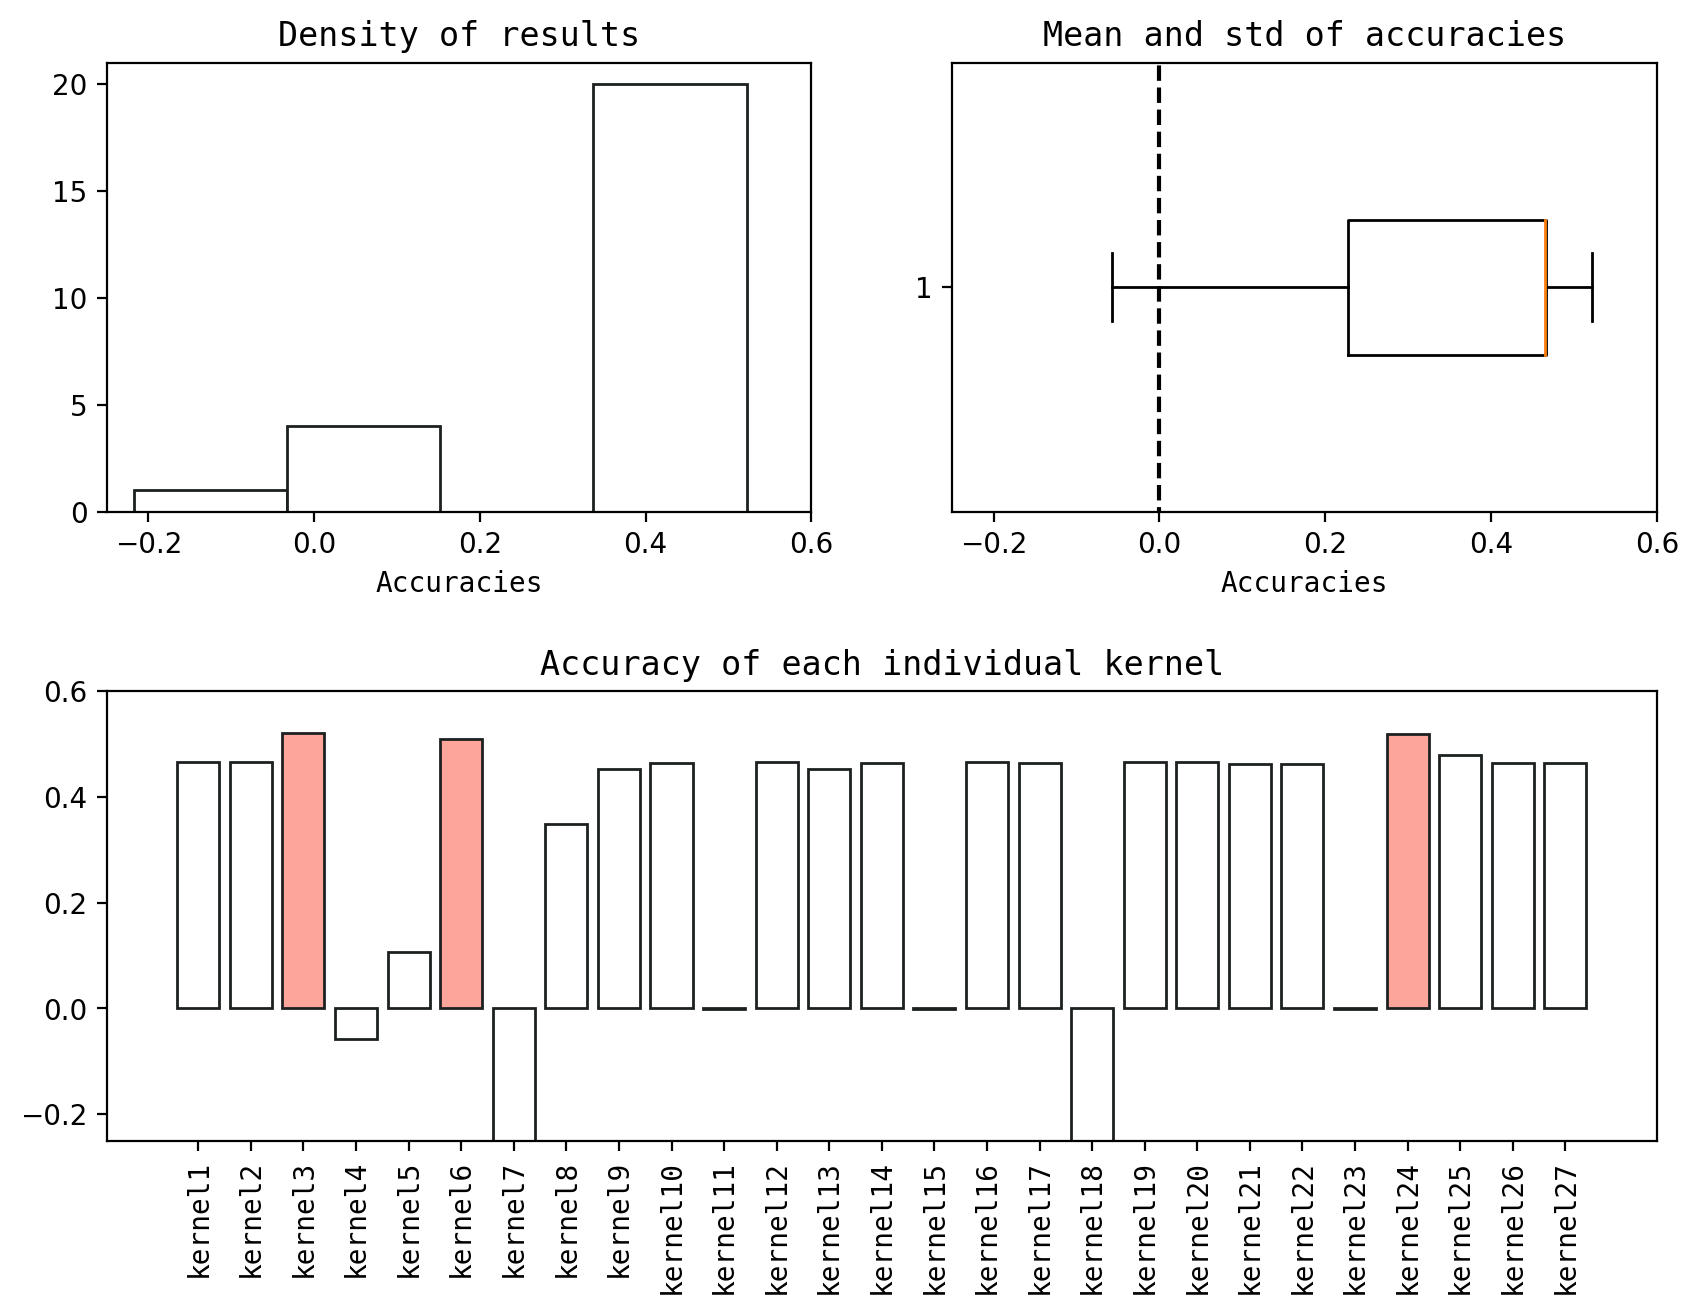

In [25]:
# create plotting figures 
fig, axs = plt.subplot_mosaic([
    ["hist", "box"],
    ["bar", "bar"]
], figsize=(10,7))

n_kernels = len(kernel_list)
kernel_varnames = [f"kernel{i+1}" for i in range(n_kernels)]

#Set horizontal space space between plots
fig.subplots_adjust(hspace=.4)

# Paint in red wich are above .50 
which_larger50pc = np.where(kernel_results > 0.5)[0]

#Barplot
barplot_colors = ["#ffffff" if i not in which_larger50pc else "#fda59b" for i in range(n_kernels)]
axs["bar"].bar(kernel_varnames, kernel_results, color = barplot_colors, edgecolor="#1d2021")
axs["bar"].set_ylim((-0.25, 0.6))
axs["bar"].set_xticklabels(kernel_varnames, rotation=90, fontfamily="monospace")
axs["bar"].set_title("Accuracy of each individual kernel", fontfamily="monospace")

#Boxplot
axs["box"].boxplot(kernel_results, vert=0)
axs["box"].set_xlim(-0.25, 0.6)
axs["box"].vlines(x = 0, ymin=0, ymax=2, color="black", linestyle = "--")
axs["box"].set_ylim(0.75, 1.25)
axs["box"].set_title("Mean and std of accuracies", fontfamily="monospace")
axs["box"].set_xlabel("Accuracies", fontfamily="monospace")

# Histogram
axs["hist"].hist(kernel_results, bins=25, color="#ffffff", edgecolor="#1d2021")
axs["hist"].set_xlim(-0.25, 0.6)
axs["hist"].set_title("Density of results", fontfamily="monospace")
axs["hist"].set_xlabel("Accuracies", fontfamily="monospace")

plt.plot()

As it can be seen in the graphs, most both ARD and DotProduct kernels stand out the most, and we can see the ExpSine kenels are around an accuracy of 0 (*the same as if they where predicting the mean*), except for the ExpSine() variant without the WhiteKernel(), which goes out of bounds (not shown in the plot) to an accuracy of -4.

The rest of kernels have a more or less similar accuracy, giving an accuracy of about 0.45.

# Items for discussion
**Which strategy turned out to be the best in terms of increasing the performance of the GP?**
- Both **scaling** and **feature extraction in the ARD kernel** techniques resulted in the same performance of 0.52 for both the Gaussian Processes. The only difference between the two techniques is that scaling our data isn't always the best alternative, as doing so we loose information about the magnitude of the data's variance is the process. As some kernels are very dependent on the variance, this doesn't always give the best results.
> TLDR: Both alternatives gave the same results, but we should avoid scaling when possible

**Did this strategy performed significantly better than the others?**
- No, as mentioned in the latter section, both strategies gave the same resuults. Overall, all the kernel, variable, and scaling combinations we carried out resulted in an accuracy around 0.45-0.5.

**Kernel design pushes the GP model further into the **black box method** region, what is the price you pay for sticking to the more interpretable ARD kernel in terms of accuracy?**

- In this particular case the usage of more complex kernels and their combinations does not yield much improvement as its performance is mostly lower than that achieved by the more interpretable ARD kernel. A particular case is that of $\text{kernel 24}$ which has a comparable performance to the ARD kernel, but then again, it is partially defined by the ARD kernel. On the other hand, what we are really paying for by using the more interpretable ARD kernel is that we are incurring in a larger bias, and pottentially worse fits to our data (again, not the case in this practice).